# Steam Search Engine - Evaluation
This document aims to evaluate the performances of the search engine through a series of measures.
The set of queries considered in the computations is defined in "queries.json".
All the measures are applied to the different versions of the project:
- base version, ranking model: BM25F;
- sentiment analysis v1: every game sentiment value is obtained from the average of its reviews sentiment values;
- sentiment analysis v2: every game sentiment value is obatined from the inverted neutral weighted average of its reviews sentiment values.

Note:

> For the benchmarks to work, it is necessary to create previously the indexes (`inedexdir/base, indexdir/sentiment`).

To create all the indexes:
`python3 -m setup` or download the pre-created indexes from the GitHub repository.

## Benchmarks
The following code retrieves the queries set and creates the Benchmarks object `b`.

In [2]:
import os
import json
from BenchmarkUtilities.benchmarks import Benchmarks

# file containing benchmark queries
file_path = os.path.join("BenchmarkUtilities", "queries.json")

with open(file_path) as f:
    queries = json.load(f)

b = Benchmarks(queries)

To have the indexes of each query of the benchmark queries set:

In [3]:
indexes = [i for i in range(len(b.queries))]
print("Benchmark queries' indexes:")
print(' '.join(map(str, indexes)))

Benchmark queries' indexes:
0 1 2 3 4 5 6 7 8 9


Some measures are executed on a specific query of the benchmark queries set.  
Set the variable `examined_q` to one of the benchmark queries' indexes (printed above) to apply those measures to a chosen query.

In [5]:
try:
    examined_q = 7
    print("User Information Need: " + b.queries[examined_q]["UIN"])
except IndexError as e:
    print(e)
    print("index not valid")

User Information Need: Best first person shooters developed by Valve


To open the indexes and create the GameSearcher objects for each version:

In [6]:
from whoosh.index import open_dir
from MainImplementation.GameSearcher import GameSearcher
import seaborn as sns
import pandas as pd

indexdirBase = "indexdir/base"
indexdirSentiment = "indexdir/sentiment"
if (not os.path.exists(indexdirBase) and not os.path.exists(indexdirSentiment)):
        raise Exception("Index not found")
# create the 2 index objects corresponding to the main index and the sentiment index
main_idxb, reviews_idxb = open_dir(indexdirBase + "/main_index"), open_dir(indexdirBase + "/reviews_index")
main_idxs, reviews_idxs = open_dir(indexdirSentiment + "/main_index"), open_dir(indexdirSentiment + "/reviews_index")

# there is one GameSearcher object for every version of the engine
SearcherBaseVersion = GameSearcher(main_idxb, reviews_idxb)
SearcherSentimentAV = GameSearcher(main_idxs, reviews_idxs, True, "av")
SearcherSentimentINAV = GameSearcher(main_idxs, reviews_idxs, True, "inav")

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


### Interpolated Precision
Precision of the examined query `examined_q` at every standard recall level.

UIN: Best first person shooters developed by Valve
Query: valve fps \sentiment[very good],
Fields: developer, cgt
Relevant documents: 30, 80, 10, 20, 70, 240, 220, 380, 420, 300, 500, 550, 440


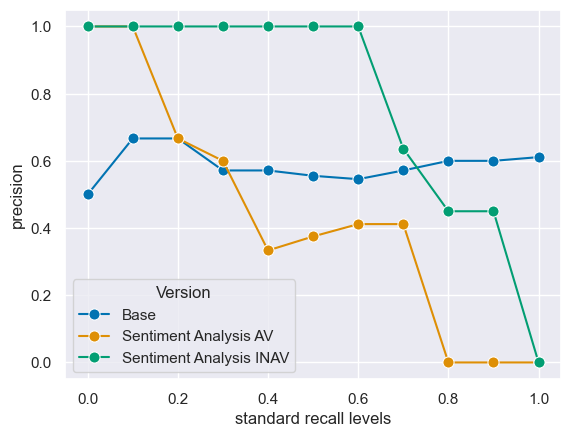

In [7]:
# search using the benchmark query and its fields
answerB = SearcherBaseVersion.search(b.queries[examined_q]["query"], b.queries[examined_q]["fields"])
answerAV = SearcherSentimentAV.search(b.queries[examined_q]["query"], b.queries[examined_q]["fields"])
answerINAV = SearcherSentimentINAV.search(b.queries[examined_q]["query"], b.queries[examined_q]["fields"])

# exctract the app_id field from the retrieved games
aB = [int(x["app_id"]) for x in answerB]
aAV = [int(x["app_id"]) for x in answerAV]
aINAV = [int(x["app_id"]) for x in answerINAV]

# compute the precision at Standard Recall Levels
pB = b.precisionSRL(b.precisionNRL(b.queries[examined_q]["relevant_documents"], aB))
pAV = b.precisionSRL(b.precisionNRL(b.queries[examined_q]["relevant_documents"], aAV))
pINAV = b.precisionSRL(b.precisionNRL(b.queries[examined_q]["relevant_documents"], aINAV))

# plot the precisions
# apply the default theme
sns.set_theme()

axes = ["standard recall levels", "precision"]

dfB = pd.DataFrame(pB, columns = axes)
dfB["Version"] = "Base"

dfAV = pd.DataFrame(pAV, columns = axes)
dfAV["Version"] = "Sentiment Analysis AV"

dfINAV = pd.DataFrame(pINAV, columns = axes)
dfINAV["Version"] = "Sentiment Analysis INAV"

# create a dataframe for Seaborn
df = pd.concat([dfB, dfAV, dfINAV])

# print the examined query
b.print_query(examined_q)

# plot the line graph
pltP = sns.lineplot(data = df, x = 'standard recall levels', y = 'precision', marker='o', markersize=8, 
             hue="Version", palette="colorblind")

# set fixed axes, the semicolon suppress the output
pltP.set_xlim([-0.05, 1.05]);
pltP.set_ylim([-0.05, 1.05]);

### Average Precision
Average precision at each standard recall level across all queries of the benchmark queries set.  
Evaluates overall system performance on a query corpus.

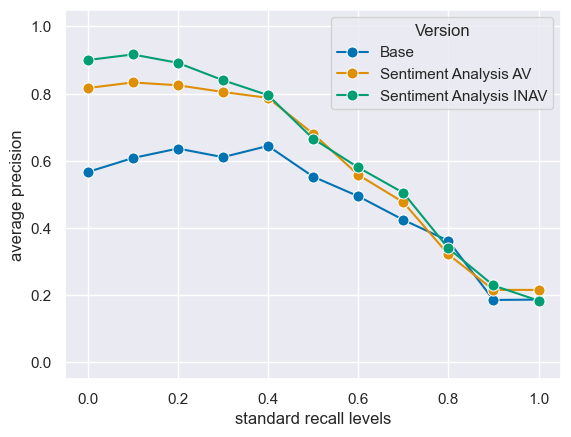

In [8]:
# compute answers list for all the benchmark queries 
answersB = []
answersAV = []
answersINAV = []
for q in range(len(b.queries)):
    answersB.append(SearcherBaseVersion.search(b.queries[q]["query"], b.queries[q]["fields"]))
    answersAV.append(SearcherSentimentAV.search(b.queries[q]["query"], b.queries[q]["fields"]))
    answersINAV.append(SearcherSentimentINAV.search(b.queries[q]["query"], b.queries[q]["fields"]))

# exctract the app_id field from the retrieved games
asB = []
asAV = []
asINAV = []
for q in range(len(b.queries)):
    asB.append([int(x["app_id"]) for x in answersB[q]])
    asAV.append([int(x["app_id"]) for x in answersAV[q]])
    asINAV.append([int(x["app_id"]) for x in answersINAV[q]])
    
# compute the precision at Standard Recall Levels
psB = []
psAV = []
psINAV = []
for q in range(len(b.queries)):
    psB.append(b.precisionSRL(b.precisionNRL(b.queries[q]["relevant_documents"], asB[q])))
    psAV.append(b.precisionSRL(b.precisionNRL(b.queries[q]["relevant_documents"], asAV[q])))
    psINAV.append(b.precisionSRL(b.precisionNRL(b.queries[q]["relevant_documents"], asINAV[q])))
    
# compute the average precision (for each version) over the benchmark queries set
avpB = b.AveragePrecision(psB)
avpAV = b.AveragePrecision(psAV)
avpINAV = b.AveragePrecision(psINAV)

# plot the average precisions
# apply the default theme
sns.set_theme()

axes = ["standard recall levels", "average precision"]

dfB = pd.DataFrame(avpB, columns = axes)
dfB["Version"] = "Base"

dfAV = pd.DataFrame(avpAV, columns = axes)
dfAV["Version"] = "Sentiment Analysis AV"

dfINAV = pd.DataFrame(avpINAV, columns = axes)
dfINAV["Version"] = "Sentiment Analysis INAV"

# create a dataframe for Seaborn
df = pd.concat([dfB, dfAV, dfINAV])

# plot the line graph
pltAvp = sns.lineplot(data = df, x = 'standard recall levels', y = 'average precision', marker='o', markersize=8, 
             hue="Version", palette="colorblind")

# set fixed axes, the semicolon suppress the output
pltAvp.set_xlim([-0.05, 1.05]); # set x-axis
pltAvp.set_ylim([-0.05, 1.05]); # set y-axis

### Interpolated Average Precision for an examined query
Single average precision value computed on the examined query `examined_q`.

UIN: Best first person shooters developed by Valve
Query: valve fps \sentiment[very good],
Fields: developer, cgt
Relevant documents: 30, 80, 10, 20, 70, 240, 220, 380, 420, 300, 500, 550, 440

Average precision: 
	Base: 0.5872491145218416
	Sentiment Analysis AV: 0.4362299465240642
	Sentiment Analysis INAV: 0.7760330578512395


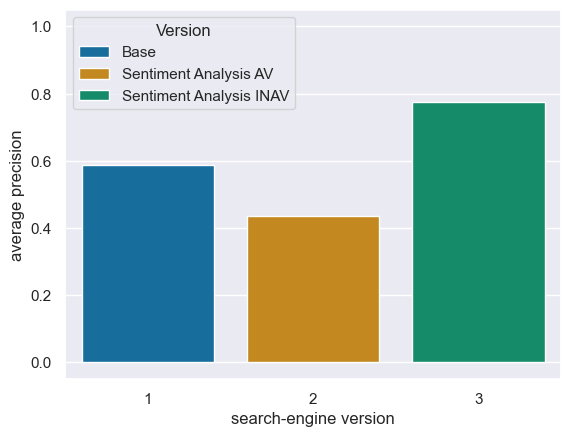

In [9]:
# search using the benchmark query and its fields
answerB = SearcherBaseVersion.search(b.queries[examined_q]["query"], b.queries[examined_q]["fields"])
answerAV = SearcherSentimentAV.search(b.queries[examined_q]["query"], b.queries[examined_q]["fields"])
answerINAV = SearcherSentimentINAV.search(b.queries[examined_q]["query"], b.queries[examined_q]["fields"])

# exctract the app_id field from the retrieved games
aB = [int(x["app_id"]) for x in answerB]
aAV = [int(x["app_id"]) for x in answerAV]
aINAV = [int(x["app_id"]) for x in answerINAV]

# compute the interpolated average precision at Standard Recall Levels
BIntAvP = b.InterAvgPrec(b.precisionSRL(b.precisionNRL(b.queries[examined_q]["relevant_documents"], aB)))
AVIntAvP = b.InterAvgPrec(b.precisionSRL(b.precisionNRL(b.queries[examined_q]["relevant_documents"], aAV)))
INAVIntAvP = b.InterAvgPrec(b.precisionSRL(b.precisionNRL(b.queries[examined_q]["relevant_documents"], aINAV)))

# print the average precision for each version
b.print_query(examined_q)
print()
print("Average precision: ")
print(f"\tBase: {BIntAvP}")
print(f"\tSentiment Analysis AV: {AVIntAvP}")
print(f"\tSentiment Analysis INAV: {INAVIntAvP}")

# plot the average precisions
# apply the default theme
sns.set_theme()

versionHUE = ["Base", "Sentiment Analysis AV", "Sentiment Analysis INAV"]
versions = [1, 2, 3]
AvPs = [BIntAvP, AVIntAvP, INAVIntAvP]

# create a dataframe for Seaborn
df = pd.DataFrame({"search-engine version": versions, "average precision": AvPs, "Version": versionHUE})

# plot the bar graph
pltAvps = sns.barplot(data = df, x = "search-engine version", y = 'average precision', palette="colorblind", hue="Version")

# set fixed axes, the semicolon suppress the output
pltAvps.set_ylim([-0.05, 1.05]); # set y-axis


### Mean Average Precision (MAP)
The average of the average precisions across multiple queries.

Mean Average Precision: 
	Base: 0.479479686979687
	Sentiment Analysis AV: 0.594228500257912
	Sentiment Analysis INAV: 0.6225102942215242


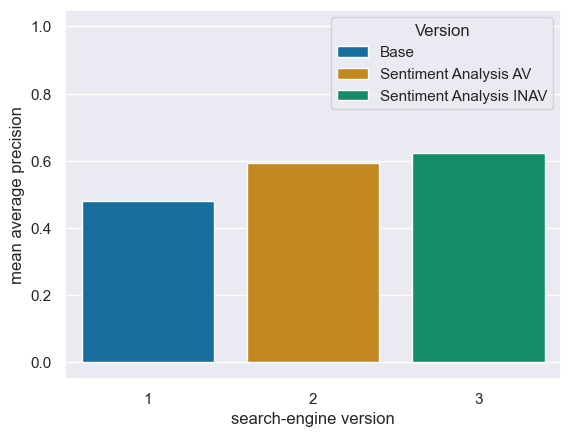

In [10]:
# compute answers list for all the benchmark queries 
answersB = []
answersAV = []
answersINAV = []
for q in range(len(b.queries)):
    answersB.append(SearcherBaseVersion.search(b.queries[q]["query"], b.queries[q]["fields"]))
    answersAV.append(SearcherSentimentAV.search(b.queries[q]["query"], b.queries[q]["fields"]))
    answersINAV.append(SearcherSentimentINAV.search(b.queries[q]["query"], b.queries[q]["fields"]))

# exctract the app_id field from the retrieved games
asB = []
asAV = []
asINAV = []
for q in range(len(b.queries)):
    asB.append([int(x["app_id"]) for x in answersB[q]])
    asAV.append([int(x["app_id"]) for x in answersAV[q]])
    asINAV.append([int(x["app_id"]) for x in answersINAV[q]])

# compute the interpolated average precision at Standard Recall Levels
IntAvPsB = []
IntAvPsAV = []
IntAvPsINAV = []
for q in range(len(b.queries)):
    IntAvPsB.append(b.InterAvgPrec(b.precisionSRL(b.precisionNRL(b.queries[q]["relevant_documents"], asB[q]))))
    IntAvPsAV.append(b.InterAvgPrec(b.precisionSRL(b.precisionNRL(b.queries[q]["relevant_documents"], asAV[q]))))
    IntAvPsINAV.append(b.InterAvgPrec(b.precisionSRL(b.precisionNRL(b.queries[q]["relevant_documents"], asINAV[q]))))

# compute the Mean Average Precision (for each version) over the benchmark queries set
MapB = b.MAP(IntAvPsB)
MapAV = b.MAP(IntAvPsAV)
MapINAV = b.MAP(IntAvPsINAV)

# print the MAP for each version
print("Mean Average Precision: ")
print(f"\tBase: {MapB}")
print(f"\tSentiment Analysis AV: {MapAV}")
print(f"\tSentiment Analysis INAV: {MapINAV}")

# plot mean average precisions
# apply the default theme
sns.set_theme()

versionHUE = ["Base", "Sentiment Analysis AV", "Sentiment Analysis INAV"]
versions = [1, 2, 3]
Maps = [MapB, MapAV, MapINAV]

# create a dataframe for Seaborn
df = pd.DataFrame({"search-engine version": versions, "mean average precision": Maps, "Version": versionHUE})

# plot the bar graph
pltMap = sns.barplot(data = df, x = "search-engine version", y = 'mean average precision', palette="colorblind", hue="Version")

# set fixed axes, the semicolon suppress the output
pltMap.set_ylim([-0.05, 1.05]); # set y-axis

### R-Precision
Precision at R-th position in the ranking of results for a query that has R relevant documents.

In [9]:
# compute answers list for all the benchmark queries 
answersB = []
answersAV = []
answersINAV = []
for q in range(len(b.queries)):
    answersB.append(SearcherBaseVersion.search(b.queries[q]["query"], b.queries[q]["fields"]))
    answersAV.append(SearcherSentimentAV.search(b.queries[q]["query"], b.queries[q]["fields"]))
    answersINAV.append(SearcherSentimentINAV.search(b.queries[q]["query"], b.queries[q]["fields"]))
    
# exctract the app_id field from the retrieved games
asB = []
asAV = []
asINAV = []
for q in range(len(b.queries)):
    asB.append([int(x["app_id"]) for x in answersB[q]])
    asAV.append([int(x["app_id"]) for x in answersAV[q]])
    asINAV.append([int(x["app_id"]) for x in answersINAV[q]])
    
# create a list with all the versions' answers
AsVersions = {
    "Base" : asB,
    "AV" : asAV,
    "INAV" : asINAV
}

Set `v1` and `v2` variables to the versions of the search engine whose R-precisions you want to compare.

In [10]:
v1 = "Base"
v2 = "INAV"

if (v1 not in AsVersions or v2 not in AsVersions):
    raise Exception("Version not valid")

Compute and plot R-precision histogram.  
For the queries that do not have sentiment part, the R-precisions' subtraction will be zero, since the output is the same for Base version and Sentiment versions.

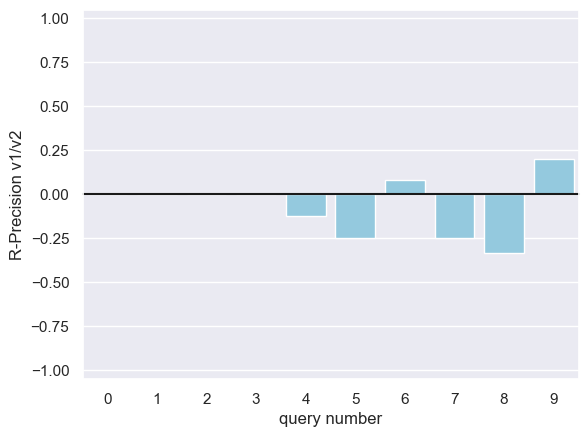

In [11]:
RPs = b.RPrecisions(AsVersions[v1], AsVersions[v2])

# plot the R precisions
# apply the default theme
sns.set_theme()

# create a DataFrame for Seaborn
df = pd.DataFrame({"query number": [x for x in range(len(b.queries))], "R-Precision v1/v2": RPs})

# use Seaborn to create a bar plot
pltRP = sns.barplot(data=df, x='query number', y='R-Precision v1/v2', color="skyblue")

# add a line to separate the positive area to the negative one
pltRP.axhline(0, color='k', clip_on=False)

# set fixed axes, the semicolon suppress the output
pltRP.set_ylim([-1.05, 1.05]);  # Set y-axis limits

### Harmonic Mean (F-Measure)
Single value measure which combines recall and precision of the examined query `examined_q`.  
High value only when both recall and precision are high.

UIN: Best first person shooters multiplayer on MacOS
Query: fps multiplayer mac \sentiment[very good]
Fields: platforms, cgt
Relevant documents: 10, 240, 80, 10180, 2630, 440, 550, 91600

Harmonic mean: 
	Base: 0.28571428571428575
	Sentiment Analysis AV: 0.4285714285714285
	Sentiment Analysis INAV: 0.4285714285714285


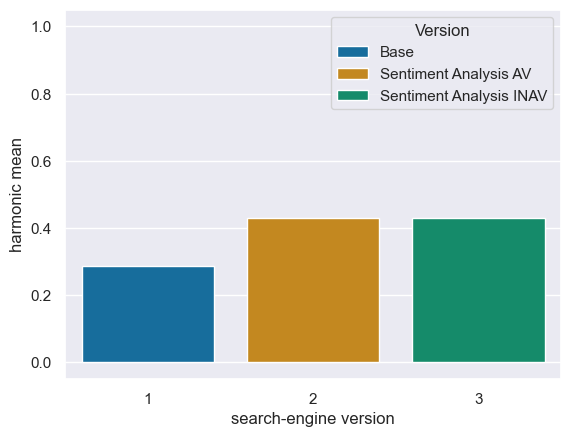

In [12]:
# search using the benchmark query and its fields
answerB = SearcherBaseVersion.search(b.queries[examined_q]["query"], b.queries[examined_q]["fields"])
answerAV = SearcherSentimentAV.search(b.queries[examined_q]["query"], b.queries[examined_q]["fields"])
answerINAV = SearcherSentimentINAV.search(b.queries[examined_q]["query"], b.queries[examined_q]["fields"])

# exctract the app_id field from the retrieved games
aB = [int(x["app_id"]) for x in answerB]
aAV = [int(x["app_id"]) for x in answerAV]
aINAV = [int(x["app_id"]) for x in answerINAV]

# compute the F-Measure (Harmonic Mean)
FmB = b.FMeasure(b.queries[examined_q]["relevant_documents"], aB)
FmAV = b.FMeasure(b.queries[examined_q]["relevant_documents"], aAV)
FmINAV = b.FMeasure(b.queries[examined_q]["relevant_documents"], aINAV)

# print the average precision for each version
b.print_query(examined_q)
print()
print("Harmonic mean: ")
print(f"\tBase: {FmB}")
print(f"\tSentiment Analysis AV: {FmAV}")
print(f"\tSentiment Analysis INAV: {FmINAV}")

# plot the average precisions
# apply the default theme
sns.set_theme()

versionHUE = ["Base", "Sentiment Analysis AV", "Sentiment Analysis INAV"]
versions = [1, 2, 3]
Fms = [FmB, FmAV, FmINAV]


# create a dataframe for Seaborn
df = pd.DataFrame({"search-engine version": versions, "harmonic mean": Fms, "Version": versionHUE})

# plot the bar graph
pltFm = sns.barplot(data = df, x = "search-engine version", y = 'harmonic mean', palette="colorblind", hue="Version")

# set fixed axes, the semicolon suppress the output
pltFm.set_ylim([-0.05, 1.05]); # set y-axis

### E-Measure
It allows the user to specify whether they are more interested in recall or in precision.  
Modify the `EMeasure_b` variable to change wheights of recall and precision: 
- `EMeasure_b = 1` to get the complement of harmonic mean
- `EMeasure_b > 1` to emphasize precision
- `0 <= EMeasure_b < 1` to emphasize recall

UIN: Best first person shooters multiplayer on MacOS
Query: fps multiplayer mac \sentiment[very good]
Fields: platforms, cgt
Relevant documents: 10, 240, 80, 10180, 2630, 440, 550, 91600

E-Measure: 
	Base: 0.7727272727272727
	Sentiment Analysis AV: 0.6590909090909092
	Sentiment Analysis INAV: 0.6590909090909092


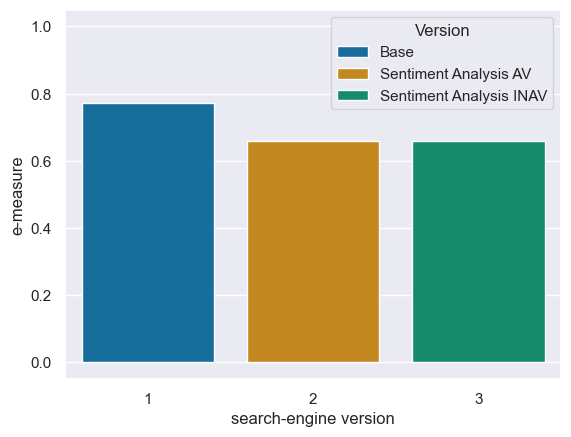

In [13]:
EMeasure_b = 0.5

# search using the benchmark query and its fields
answerB = SearcherBaseVersion.search(b.queries[examined_q]["query"], b.queries[examined_q]["fields"])
answerAV = SearcherSentimentAV.search(b.queries[examined_q]["query"], b.queries[examined_q]["fields"])
answerINAV = SearcherSentimentINAV.search(b.queries[examined_q]["query"], b.queries[examined_q]["fields"])

# exctract the app_id field from the retrieved games
aB = [int(x["app_id"]) for x in answerB]
aAV = [int(x["app_id"]) for x in answerAV]
aINAV = [int(x["app_id"]) for x in answerINAV]

# compute the E-Measure
EmB = b.EMeasure(b.queries[examined_q]["relevant_documents"], aB, EMeasure_b)
EmAV = b.EMeasure(b.queries[examined_q]["relevant_documents"], aAV, EMeasure_b)
EmINAV = b.EMeasure(b.queries[examined_q]["relevant_documents"], aINAV, EMeasure_b)

# print the average precision for each version
b.print_query(examined_q)
print()
print("E-Measure: ")
print(f"\tBase: {EmB}")
print(f"\tSentiment Analysis AV: {EmAV}")
print(f"\tSentiment Analysis INAV: {EmINAV}")

# plot the average precisions
# apply the default theme
sns.set_theme()

versionHUE = ["Base", "Sentiment Analysis AV", "Sentiment Analysis INAV"]
versions = [1, 2, 3]
Ems = [EmB, EmAV, EmINAV]

# create a dataframe for Seaborn
df = pd.DataFrame({"search-engine version": versions, "e-measure": Ems, "Version": versionHUE})

# plot the bar graph
pltEm = sns.barplot(data = df, x = "search-engine version", y = 'e-measure', palette="colorblind", hue="Version")

# set fixed axes, the semicolon suppress the output
pltEm.set_ylim([-0.05, 1.05]); # set y-axis